In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from tqdm import tqdm

In [5]:
train_audio_path = "./train/audio/"

16000
16000


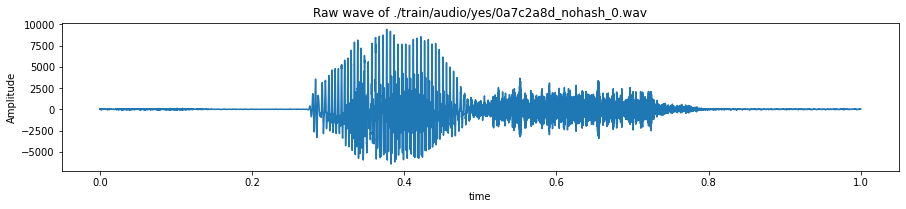

In [10]:
filename = 'yes/0a7c2a8d_nohash_0.wav'
sample_rate, samples = wavfile.read(str(train_audio_path) + filename)
fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(2, 1, 1)
ax1.set_title('Raw wave of ' + f'{str(train_audio_path) + filename}')
ax1.set_xlabel('time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)
print(sample_rate)
print(len(samples))

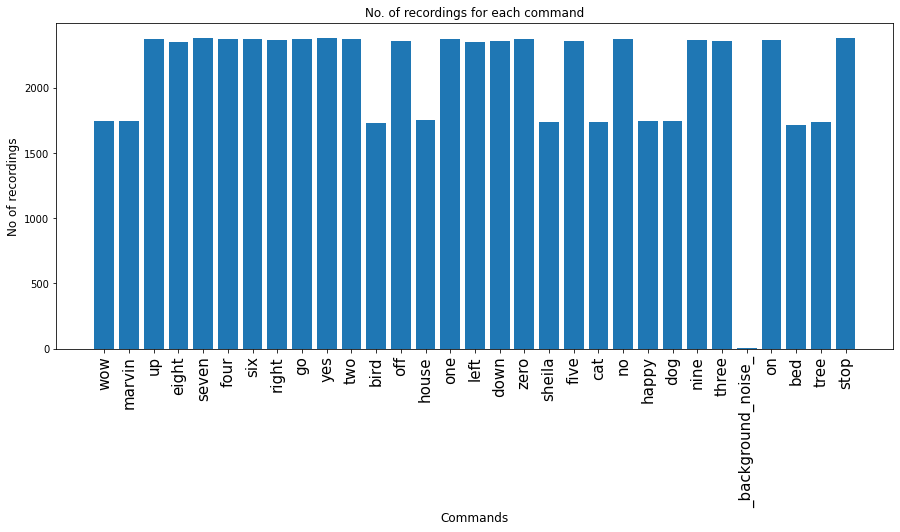

In [17]:
import os

labels = os.listdir(train_audio_path)
no_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))
    
plt.figure(figsize=(15, 6))
plt.bar(np.arange(len(labels)), no_of_recordings)
plt.xlabel('Commands', fontsize=12)
plt.ylabel('No of recordings', fontsize=12)
plt.xticks(np.arange(len(labels)), labels, fontsize=15, rotation=90)
plt.title('No. of recordings for each command')
plt.show()

In [21]:
import librosa

train_audio_path = 'train/audio/'
all_wave, all_label = [], []
for label in tqdm(labels):
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr=16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if (len(samples)==8000):
            all_wave.append(samples)
            all_label.append(label)

wow
marvin
up
eight
seven
four
six
right
go
yes
two
bird
off
house
one
left
down
zero
sheila
five
cat
no
happy
dog
nine
three
_background_noise_
on
bed
tree
stop


In [22]:
def to_categorical(y, num_classes=None, dtype='float32'):
    """
    Converts a class vector (integers) to binary class matrix.
    """
    y = np.array(y, dtype='int')
    input_shape = y.shape
    if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
        input_shape = tuple(input_shape[:-1])
    y = y.ravel()
    if not num_classes:
        num_classes = np.max(y) + 1
    n = y.shape[0]
    categorical = np.zeros((n, num_classes), dtype=dtype)
    categorical[np.arange(n), y] = 1
    output_shape = input_shape + (num_classes,)
    categorical = np.reshape(categorical, output_shape)
    return categorical

In [23]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(all_label)
classes = list(le.classes_)

In [32]:
all_wave = np.array(all_wave).reshape(-1, 8000, 1)

In [61]:
def compute_mfcc(data, n_mfcc, sr=16000):
    print('Compute MFCC, n_mfcc=' + str(n_mfcc), flush=True)
    all_mfcc = []
    for wav in tqdm(data):
        feature = librosa.feature.mfcc(wav.reshape(-1, ), 
                                       sr=sr, 
                                       n_mfcc=n_mfcc, 
                                       n_fft=int(sr*0.025),
                                       hop_length=int(sr*0.01))
        feature = feature.T
        feature = feature[:-1, :]
        all_mfcc.append(feature)
    return np.array(all_mfcc)

In [63]:
all_mfcc = compute_mfcc(all_wave[:1000], n_mfcc=20, sr=8000)

Compute MFCC, n_mfcc=20


100%|██████████| 1000/1000 [00:03<00:00, 307.12it/s]


In [67]:
import torch.nn as nn

class StatsPool(nn.Module):

    def __init__(self, floor=1e-10, bessel=False):
        super(StatsPool, self).__init__()
        self.floor = floor
        self.bessel = bessel

    def forward(self, x):
        means = torch.mean(x, dim=1)
        _, t, _ = x.shape
        if self.bessel:
            t = t - 1
        residuals = x - means.unsqueeze(1)
        numerator = torch.sum(residuals**2, dim=1)
        stds = torch.sqrt(torch.clamp(numerator, min=self.floor)/t)
        x = torch.cat([means, stds], dim=1)
        return x


class TDNN(nn.Module):

    def __init__(
        self,
        input_dim=23,
        output_dim=512,
        context_size=5,
        stride=1,
        dilation=1,
        batch_norm=True,
        dropout_p=0.0,
        padding=0
    ):
        super(TDNN, self).__init__()
        self.context_size = context_size
        self.stride = stride
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.dilation = dilation
        self.dropout_p = dropout_p
        self.padding = padding

        self.kernel = nn.Conv1d(self.input_dim,
                                self.output_dim,
                                self.context_size,
                                stride=self.stride,
                                padding=self.padding,
                                dilation=self.dilation)

        self.nonlinearity = nn.ReLU()
        self.batch_norm = batch_norm
        if batch_norm:
            self.bn = nn.BatchNorm1d(output_dim)
        self.drop = nn.Dropout(p=self.dropout_p)

    def forward(self, x):
        '''
        input: size (batch, seq_len, input_features)
        outpu: size (batch, new_seq_len, output_features)
        '''
        _, _, d = x.shape
        assert (d == self.input_dim), 'Input dimension was wrong. Expected ({}), got ({})'.format(
            self.input_dim, d)

        x = self.kernel(x.transpose(1, 2))
        x = self.nonlinearity(x)
        x = self.drop(x)

        if self.batch_norm:
            x = self.bn(x)
        return x.transpose(1, 2)